In [1]:
from pathlib import Path
import numpy as np

In [2]:
import yaml
# pip install pyyaml-include
from yamlinclude import YamlIncludeConstructor

In [3]:
from matplotlib import pyplot as plt
plt.style.use('jupyter_dark')

In [4]:
from pyomo import environ as pyo

In [5]:
from interarray.interarraylib import L_from_site, as_normalized, G_from_S
from interarray.svg import svgplot
from interarray.plotting import gplot
from interarray.mesh import make_planar_embedding
from interarray.pathfinding import PathFinder
from interarray.interface import assign_cables
from interarray.MILP import pyomo as omo
from interarray.baselines.hgs import iterative_hgs_cvrp

## Load layouts from files

In [6]:
# Wind farms stored according to the windIO format
# https://windio.readthedocs.io/en/latest/

yaml.add_constructor(
    "!include", YamlIncludeConstructor(base_dir='.'))

def load_windIO(filepath):
    fpath = Path(filepath)
    with open(fpath, 'r') as f:
        system = yaml.full_load(f)
    coords = (system['wind_farm']['layouts']['initial_layout']
              ['coordinates'])
    terminalC = np.c_[coords['x'], coords['y']]
    coords = system['wind_farm']['electrical_substations']['coordinates']
    rootC = np.c_[coords['x'], coords['y']]
    coords = system['site']['boundaries']['polygons'][0]
    borderC = np.c_[coords['x'], coords['y']]
    T = terminalC.shape[0]
    R = rootC.shape[0]
    name_tokens = fpath.stem.split('_')
    return L_from_site(
        R=R, T=T,
        VertexC=np.vstack((terminalC, borderC, rootC)),
        border=np.arange(T, T + borderC.shape[0]),
        name=' '.join(name_tokens),
        handle=(f'{name_tokens[0].lower()}_'
                f'{name_tokens[1][:4].lower()}_'
                f'{name_tokens[2][:3].lower()}'),
    )

In [7]:
L_reg = load_windIO('IEA37_Borssele_Regular_System.yaml')

In [8]:
L_irr = load_windIO('IEA37_Borssele_Irregular_System.yaml')

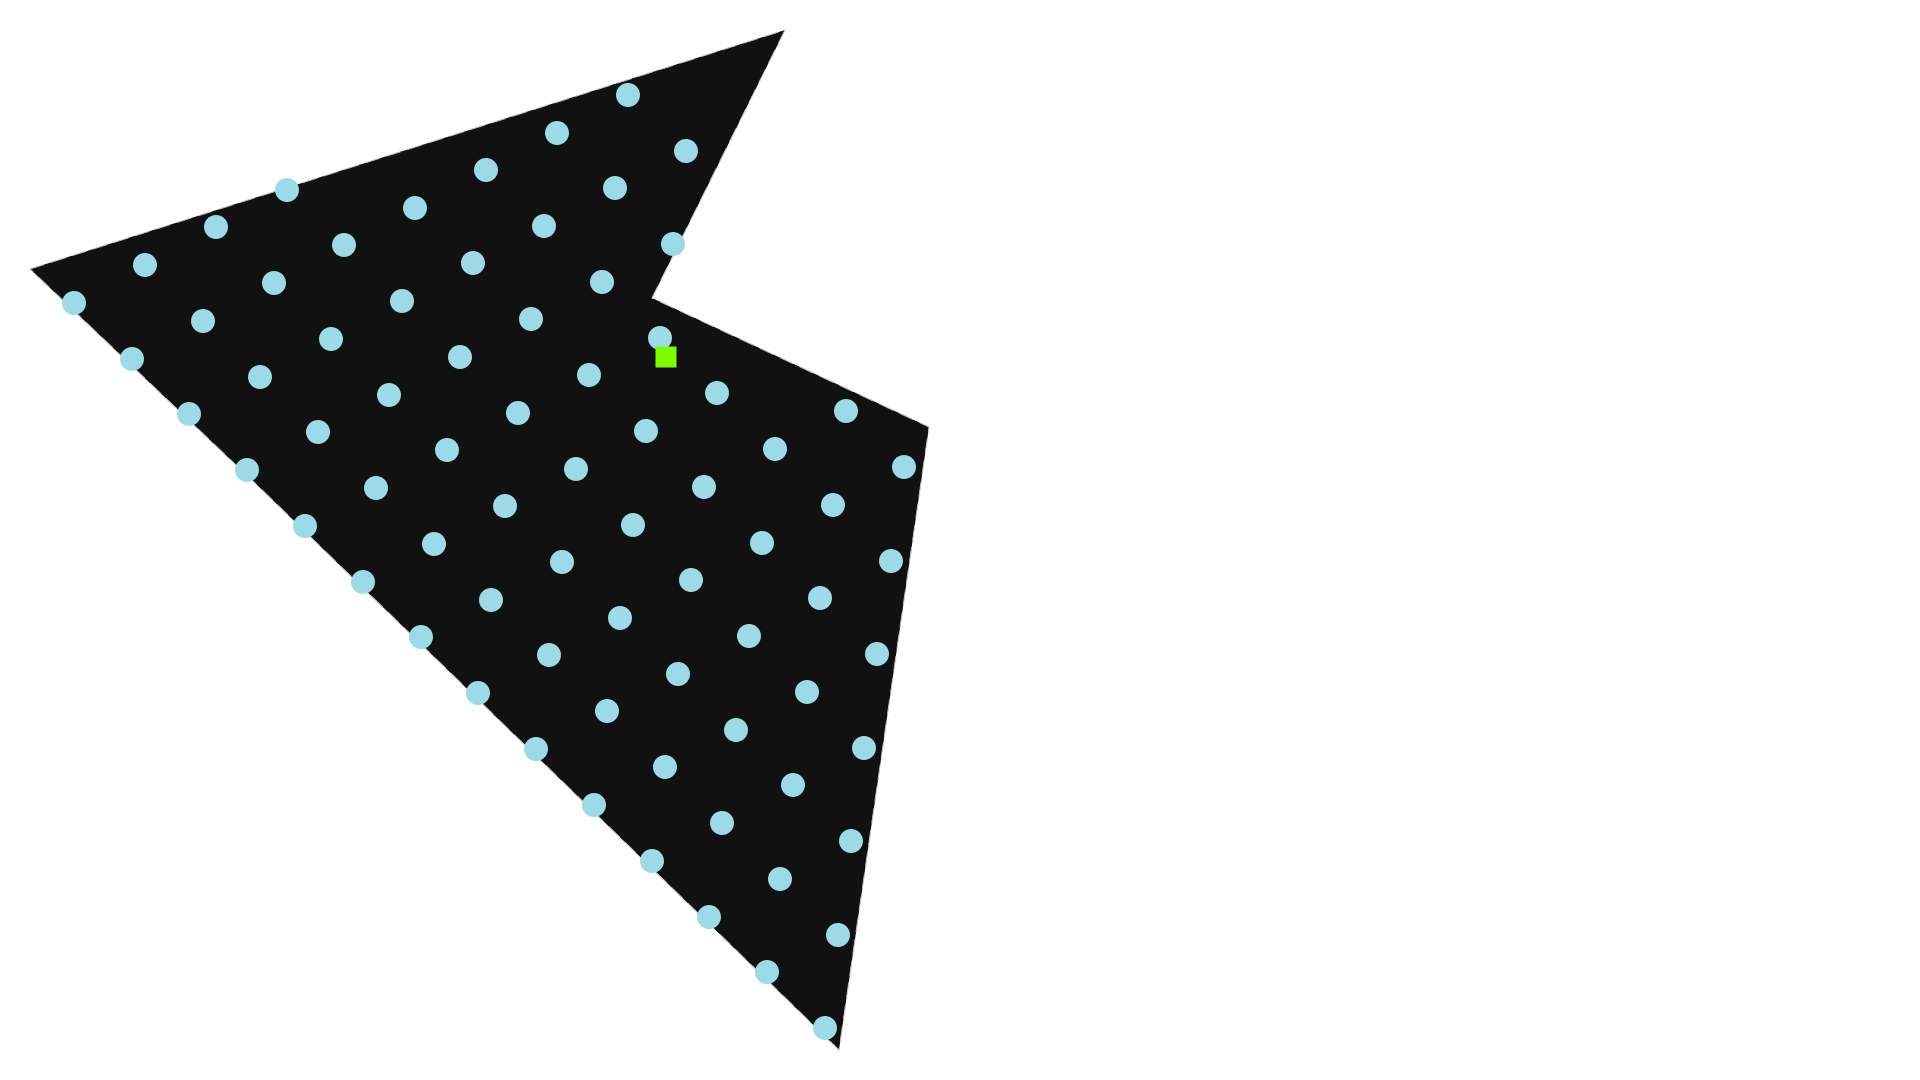

In [9]:
svgplot(L_reg)

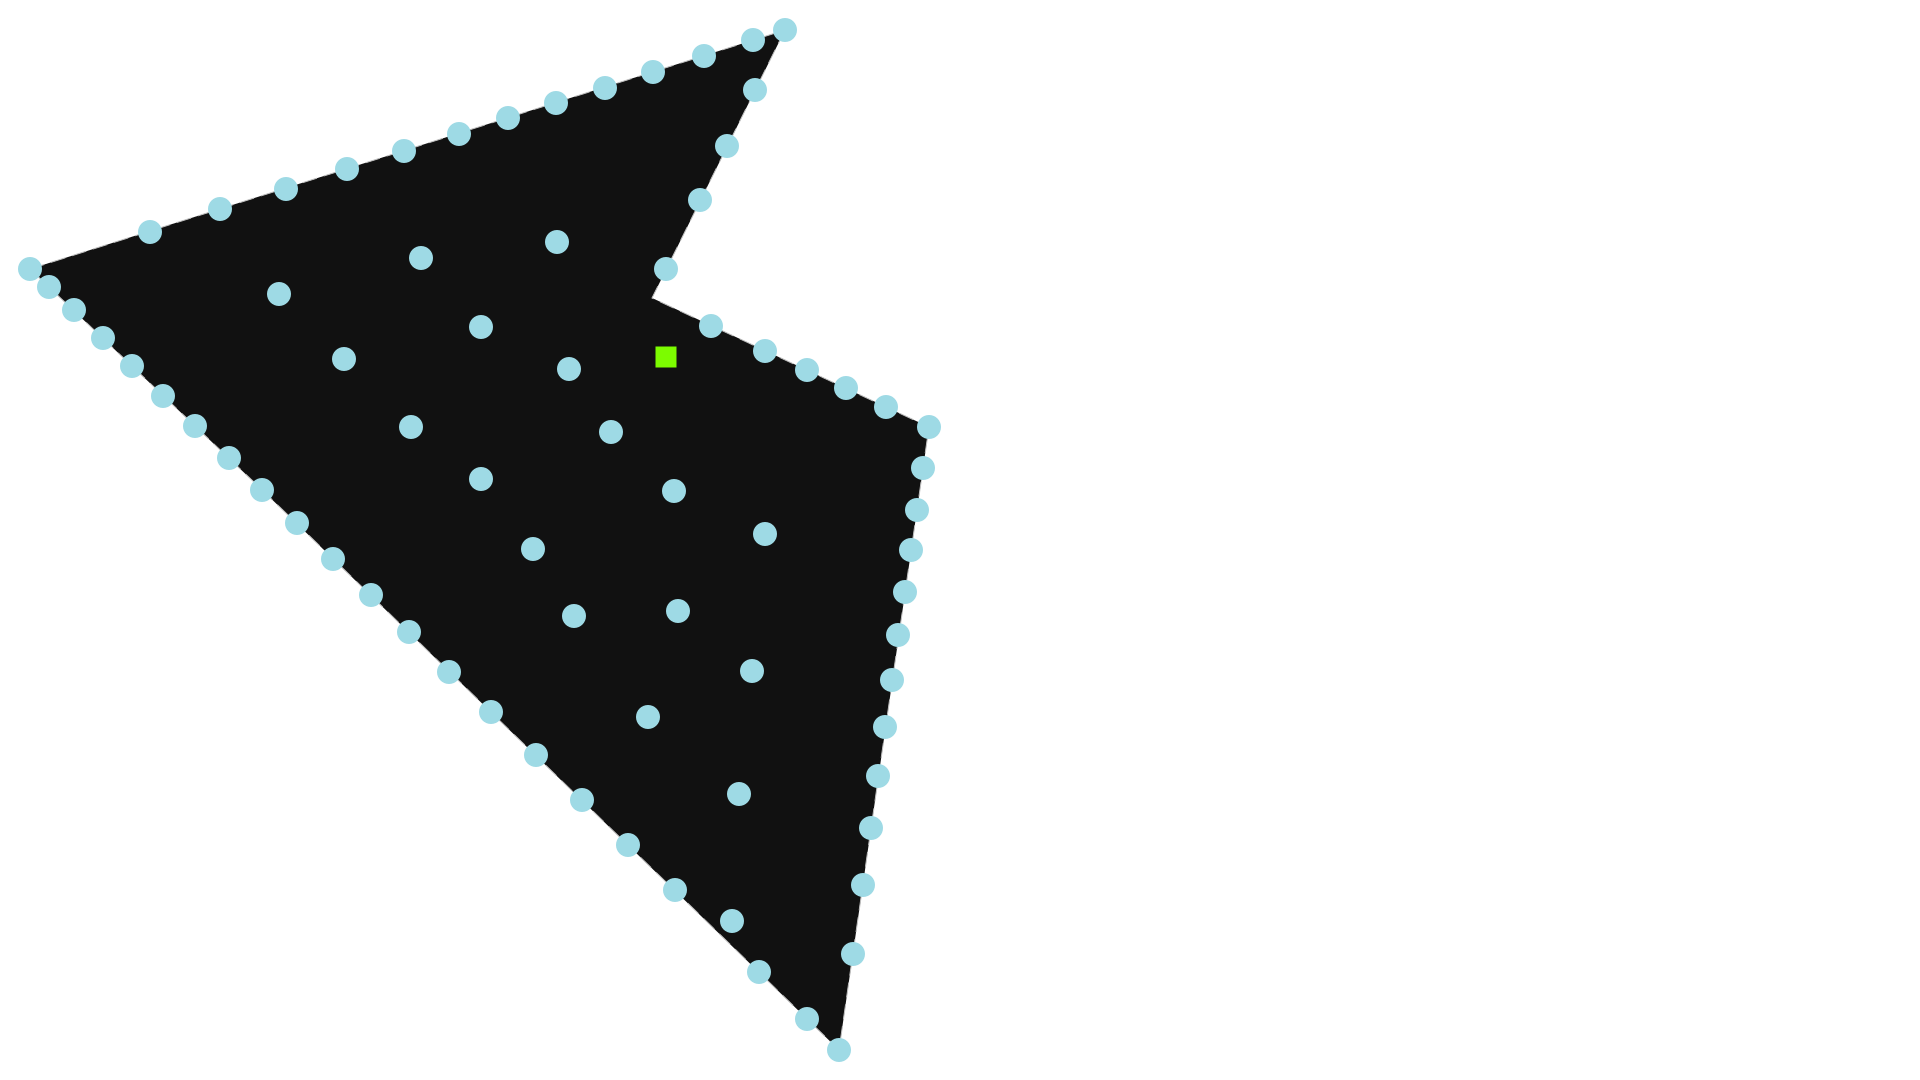

In [10]:
svgplot(L_irr)

## Additional design parameters

In [11]:
cable_costs = [206, 287, 406]  # [€/m] Costs per distance for each cable type
turbines_per_cable = [3, 5, 7]

In [12]:
cables = [(None, capacity, cost) for capacity, cost in zip(turbines_per_cable, cable_costs)]
capacity = max(turbines_per_cable)

## Choose solver

In [13]:
solver = pyo.SolverFactory('gurobi', solver_io='python')
solver.available()

True

In [14]:
solver.options.update(dict(
    mipgap=0.005,  # 0.5 %
    timelimit=7,  # [s]
    mipfocus=1,  # focus on producing solutions
))

## Regular layout

In [15]:
P, A = make_planar_embedding(L_reg)

In [18]:
# This meta-heuristic call is iterative and the time_limit applies
# to each iteration. About 97% of instances use a single iteration.
S_warm = iterative_hgs_cvrp(as_normalized(A), capacity=capacity, time_limit=3)

In [19]:
m = omo.make_min_length_model(
    A, capacity,
    gateXings_constraint=False,
    branching=True,
    gates_limit=False
)
omo.warmup_model(m, S_warm);

In [18]:
print(f'Solving "{m.name}", capacity = {m.k.value}\n')
status = solver.solve(m, tee=True, warmstart=True)

Solving "IEA37 Borssele Regular System", capacity = 7

Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.005
Set parameter TimeLimit to value 7
Set parameter MIPFocus to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  7
MIPGap  0.005
MIPFocus  1

Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk
Optimize a model with 2454 rows, 1540 columns and 8930 nonzeros
Model fingerprint: 0x7cbb9eff
Variable types: 0 continuous, 1540 integer (770 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [4e+02, 1e+04]
  Bounds range     [1e+00, 7e+00]
  RHS range        [1e+00, 7e+01]

Loaded user MIP start with objective 139656

Presolve removed 387 rows and 0 columns
P

  RHS range        [1e+00, 7e+01]


Loaded user MIP start with objective 152084


Presolve removed 752 rows and 0 columns


Presolve time: 0.45s


Presolved: 2923 rows, 1528 columns, 11606 nonzeros


Variable types: 0 continuous, 1528 integer (764 binary)


Root relaxation: objective 1.355932e+05, 1626 iterations, 0.10 seconds (0.04 work units)


    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


     0     0 135593.250    0  146 152083.980 135593.250  10.8%     -    0s


H    0     0                    152078.33230 135593.250  10.8%     -    0s


H    0     0                    151805.89887 135593.250  10.7%     -    1s


     0     0 136362.916    0  177 151805.899 136362.916  10.2%     -    1s


H    0     0                    150726.38191 136390.136  9.51%     -    1s


     0     0 136390.136    0  187 150726.382 136390.136  9.51%     -    1s


     0     0 136390.136    0  187 150726.382 136390.136  9.51%     -    1s


H    0     0                    150712.21956 136608.324  9.36%     -    1s


     0     0 136608.324    0  215 150712.220 136608.324  9.36%     -    1s


     0     0 136679.462    0  205 150712.220 136679.462  9.31%     -    1s


     0     0 136681.649    0  224 150712.220 136681.649  9.31%     -    1s


     0     0 136681.819    0  244 150712.220 136681.819  9.31%     -    1s


H    0     0                    147988.56258 136788.519  7.57%     -    1s


     0     0 136788.519    0  236 147988.563 136788.519  7.57%     -    1s


H    0     0                    147393.30919 136798.896  7.19%     -    1s


     0     0 136829.221    0  244 147393.309 136829.221  7.17%     -    1s


     0     0 136840.487    0  275 147393.309 136840.487  7.16%     -    1s


     0     0 136842.358    0  261 147393.309 136842.358  7.16%     -    1s


     0     0 136842.358    0  261 147393.309 136842.358  7.16%     -    1s


     0     0 136879.578    0  264 147393.309 136879.578  7.13%     -    1s


     0     0 136899.836    0  265 147393.309 136899.836  7.12%     -    1s


     0     0 136904.212    0  256 147393.309 136904.212  7.12%     -    1s


     0     0 136909.840    0  249 147393.309 136909.840  7.11%     -    1s


     0     0 136911.080    0  274 147393.309 136911.080  7.11%     -    1s


     0     0 136911.372    0  265 147393.309 136911.372  7.11%     -    1s


H    0     0                    147160.12198 136929.795  6.95%     -    1s


     0     0 136929.795    0  278 147160.122 136929.795  6.95%     -    1s


     0     0 136931.096    0  272 147160.122 136931.096  6.95%     -    1s


     0     0 136931.434    0  276 147160.122 136931.434  6.95%     -    1s


     0     0 136931.556    0  276 147160.122 136931.556  6.95%     -    1s


     0     0 136962.618    0  261 147160.122 136962.618  6.93%     -    1s


     0     0 136964.970    0  241 147160.122 136964.970  6.93%     -    1s


     0     0 136966.023    0  260 147160.122 136966.023  6.93%     -    1s


     0     0 136966.524    0  267 147160.122 136966.524  6.93%     -    1s


     0     0 136976.303    0  269 147160.122 136976.303  6.92%     -    1s


     0     0 136984.683    0  278 147160.122 136984.683  6.91%     -    1s


     0     0 136987.330    0  267 147160.122 136987.330  6.91%     -    1s


     0     0 136987.391    0  271 147160.122 136987.391  6.91%     -    1s


H    0     0                    143404.88202 137024.217  4.45%     -    1s


     0     0 137024.217    0  236 143404.882 137024.217  4.45%     -    1s


     0     0 137039.534    0  247 143404.882 137039.534  4.44%     -    1s


     0     0 137039.534    0  291 143404.882 137039.534  4.44%     -    1s


     0     0 137039.534    0  303 143404.882 137039.534  4.44%     -    1s


     0     0 137060.065    0  284 143404.882 137060.065  4.42%     -    2s


H    0     0                    142449.28895 137066.703  3.78%     -    2s


     0     0 137071.175    0  285 142449.289 137071.175  3.78%     -    2s


     0     0 137074.060    0  282 142449.289 137074.060  3.77%     -    2s


     0     0 137075.409    0  290 142449.289 137075.409  3.77%     -    2s


     0     0 137075.444    0  294 142449.289 137075.444  3.77%     -    2s


     0     0 137084.170    0  276 142449.289 137084.170  3.77%     -    2s


     0     0 137086.439    0  298 142449.289 137086.439  3.76%     -    2s


     0     0 137086.764    0  297 142449.289 137086.764  3.76%     -    2s


     0     0 137102.131    0  281 142449.289 137102.131  3.75%     -    2s


     0     0 137108.573    0  296 142449.289 137108.573  3.75%     -    2s


     0     0 137108.612    0  296 142449.289 137108.612  3.75%     -    2s


     0     0 137114.768    0  294 142449.289 137114.768  3.74%     -    2s


     0     0 137116.896    0  300 142449.289 137116.896  3.74%     -    2s


     0     0 137116.896    0  300 142449.289 137116.896  3.74%     -    2s


     0     0 137117.267    0  290 142449.289 137117.267  3.74%     -    2s


     0     0 137117.965    0  288 142449.289 137117.965  3.74%     -    2s


     0     2 137118.050    0  288 142449.289 137118.050  3.74%     -    2s


H   32    56                    141443.21633 137160.936  3.03%   185    3s


H   33    56                    141437.56758 137160.936  3.02%   185    3s


H   36    56                    141114.74864 137160.936  2.80%   179    3s


H  204   228                    141109.10094 137171.900  2.79%   125    4s


H  205   228                    141109.10058 137171.900  2.79%   124    4s


H 1380  1314                    140696.72819 137171.900  2.51%  82.6    4s


  1639  1549 139319.030   49  157 140696.728 137171.900  2.51%  78.3    5s


  2948  2479 138403.284   29  311 140696.728 137372.668  2.36%  68.1   10s


  2966  2491 139517.994    7  340 140696.728 137414.443  2.33%  67.7   15s


H 3077  2456                    140591.46476 137600.419  2.13%  79.8   17s


H 3084  2335                    139593.87897 137600.419  1.43%  80.3   17s


  5064  3045 138493.870   36  269 139593.879 137601.512  1.43%  99.2   20s


  9040  3999 138934.563   36  226 139593.879 137886.819  1.22%   104   25s


 17233  7866     cutoff   38      139593.879 138144.535  1.04%   106   30s


 24237 11273 139055.188   28  224 139593.879 138235.829  0.97%   108   35s


 33241 15151 138546.093   24  221 139593.879 138338.371  0.90%   109   40s


 41675 18470 138790.755   26  236 139593.879 138406.386  0.85%   109   45s


 50374 20426 139315.681   33  288 139593.879 138463.925  0.81%   110   59s


 50377 20428 138931.731   28  262 139593.879 138463.925  0.81%   110   60s


 50406 20447 138489.254   23  316 139593.879 138463.925  0.81%   109   65s


 50425 20460 139076.058   45  339 139593.879 138463.925  0.81%   109   70s


 50440 20470 139502.582   35  333 139593.879 138463.925  0.81%   109   75s


 50456 20481 139096.232   32  337 139593.879 138463.925  0.81%   109   80s


 50471 20491 138822.765   34  345 139593.879 138463.925  0.81%   109   85s


 50488 20502 138944.839   34  349 139593.879 138463.925  0.81%   109   90s


 50504 20513 138931.751   20  349 139593.879 138463.925  0.81%   109   95s


 50518 20522 138709.204   37  363 139593.879 138463.925  0.81%   109  100s


 50698 20661 139449.629   28  254 139593.879 138463.925  0.81%   110  105s


 52579 21061     cutoff   62      139593.879 138463.925  0.81%   111  110s


 57794 21893 139191.817   58  132 139593.879 138463.925  0.81%   110  115s


 63697 22548 138523.962   33  275 139593.879 138463.925  0.81%   110  120s


 68247 22595 138727.191   34  202 139593.879 138463.925  0.81%   109  129s


 68279 22842 138751.637   35  179 139593.879 138463.925  0.81%   109  130s


 74839 23470 139058.266   40  245 139593.879 138463.925  0.81%   109  135s


 78612 23480     cutoff   44      139593.879 138463.925  0.81%   109  145s


 85731 23770 139570.049   35  255 139593.879 138480.473  0.80%   108  150s


 93386 23827 138688.274   43  234 139593.879 138531.170  0.76%   108  155s


 102230 23738     cutoff   34      139593.879 138578.904  0.73%   107  161s


*104052 21643              46    139485.54411 138583.622  0.65%   107  161s


H105586 20554                    139479.89522 138596.740  0.63%   107  163s


 107363 21005     cutoff   66      139479.895 138606.936  0.63%   107  165s


 115109 22506     cutoff   41      139479.895 138641.145  0.60%   107  170s


 123303 23823 139366.644   41  147 139479.895 138680.414  0.57%   106  175s


 132022 24788 138964.979   38  233 139479.895 138720.769  0.54%   106  181s


 136484 25598 139064.998   39  251 139479.895 138738.149  0.53%   106  186s


 146100 26428     cutoff   51      139479.895 138772.593  0.51%   105  191s


 155097 26999 139301.353   40  201 139479.895 138804.676  0.48%   105  196s


 161402 27329 139264.024   37  206 139479.895 138825.023  0.47%   105  200s


 170466 27434     cutoff   43      139479.895 138856.957  0.45%   105  205s


 179676 27365 139146.441   33   91 139479.895 138886.219  0.43%   104  211s


 189337 27285 139384.722   40  236 139479.895 138911.910  0.41%   104  220s


 197028 26820 139098.764   41  254 139479.895 138936.134  0.39%   104  226s


 203858 26314 139172.697   42  233 139479.895 138955.318  0.38%   103  230s


 213570 25314     cutoff   42      139479.895 138986.660  0.35%   103  236s


 220161 24424 139388.758   34  212 139479.895 139006.711  0.34%   103  240s


 229974 22881 139368.220   44  238 139479.895 139037.086  0.32%   102  246s


 236148 21599     cutoff   41      139479.895 139059.113  0.30%   102  250s


 245668 19119 139224.289   44  218 139479.895 139095.569  0.28%   102  256s


 252051 17306 139376.638   34   81 139479.895 139120.405  0.26%   102  260s


 258393 15150 139314.794   37  245 139479.895 139147.669  0.24%   102  265s


 268039 11195 139334.882   47  210 139479.895 139192.730  0.21%   102  271s


Cutting planes:


  Gomory: 35


  Lift-and-project: 17


  Cover: 185


  Implied bound: 10


  Projected implied bound: 5


  MIR: 1009


  StrongCG: 43


  Flow cover: 782


  Flow path: 45


  GUB cover: 1


  Inf proof: 3


  Zero half: 108


  Network: 8


  Relax-and-lift: 4


Explored 271427 nodes (27554559 simplex iterations) in 271.32 seconds (332.14 work units)


Thread count was 24 (of 24 available processors)


Solution count 10: 139480 139486 139594 ... 141443


Optimal solution found (tolerance 2.00e-03)


Best objective 1.394798952160e+05, best bound 1.392114129073e+05, gap 0.1925%


In [19]:
S_solver = omo.S_from_solution(m, solver, status)
G_solver = G_from_S(S_solver, A)
G_reg = PathFinder(G_solver, planar=P, A=A).create_detours()

In [20]:
assign_cables(G_reg, cables)
G_reg.size(weight='cost')

40714260.58298518

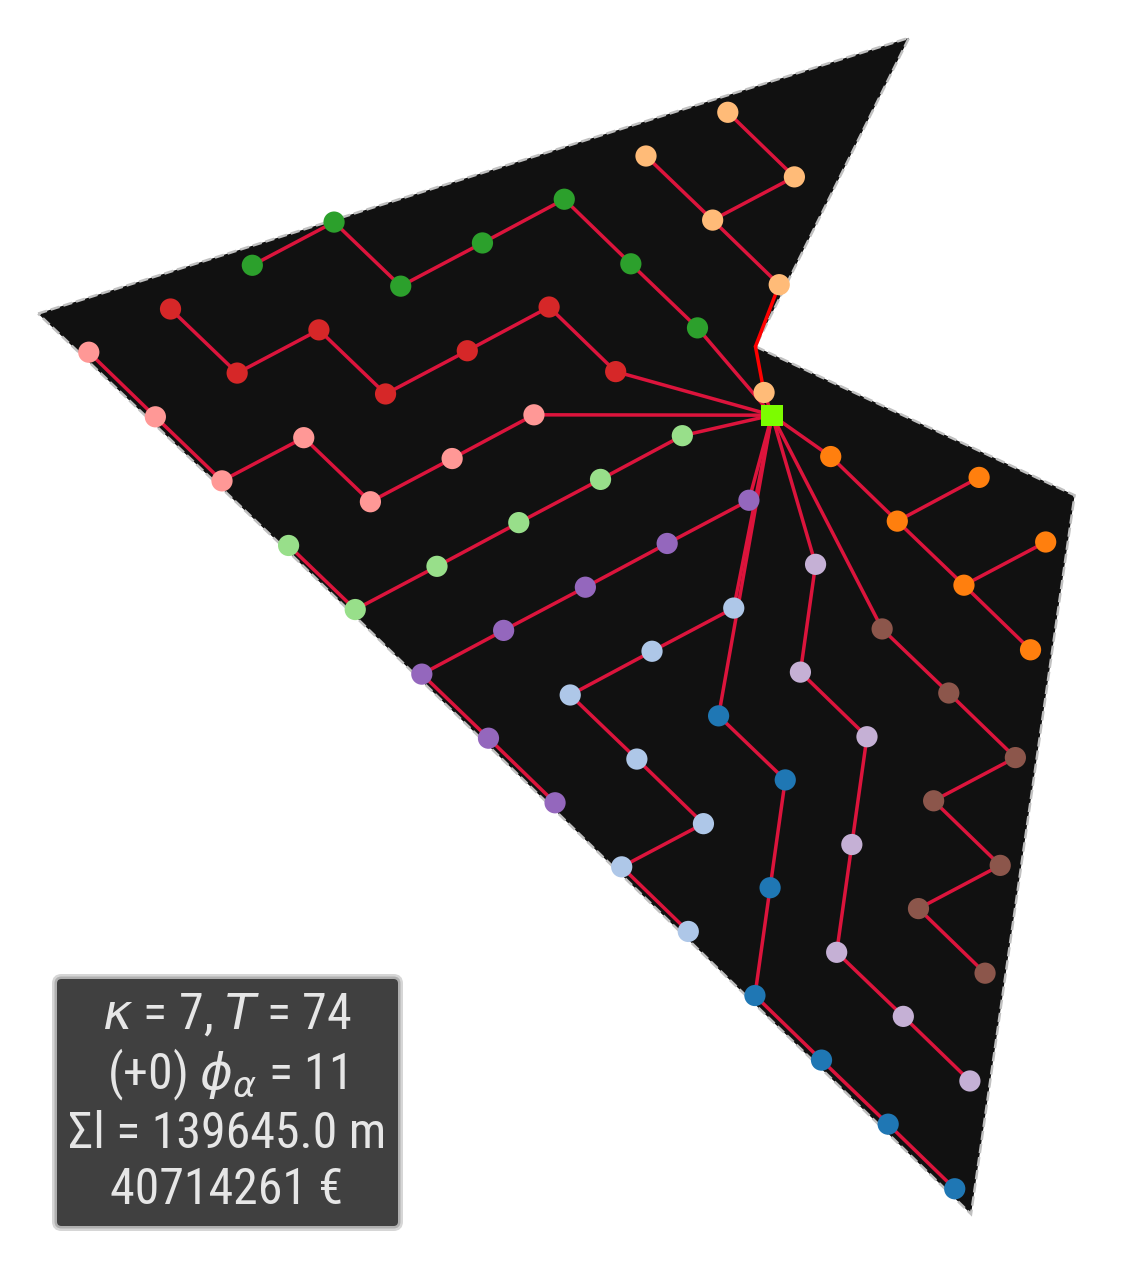

In [21]:
gplot(G_reg, node_tag=None);

If the solver is given more time (~15 min), a better solution is achieved:

In [16]:
solver.options.update(dict(
    timelimit=900,  # [s]
))

In [20]:
print(f'Solving "{m.name}", capacity = {m.k.value}\n')
status = solver.solve(m, tee=True, warmstart=True)

Solving "IEA37 Borssele Regular System", capacity = 7

Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.005
Set parameter TimeLimit to value 900
Set parameter MIPFocus to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  900
MIPGap  0.005
MIPFocus  1

Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk
Optimize a model with 2454 rows, 1540 columns and 8930 nonzeros
Model fingerprint: 0x7cbb9eff
Variable types: 0 continuous, 1540 integer (770 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [4e+02, 1e+04]
  Bounds range     [1e+00, 7e+00]
  RHS range        [1e+00, 7e+01]

Loaded user MIP start with objective 139656

Presolve removed 387 rows and 0 colum

In [21]:
S_solver = omo.S_from_solution(m, solver, status)
G_solver = G_from_S(S_solver, A)
G_reg = PathFinder(G_solver, planar=P, A=A).create_detours()

In [22]:
assign_cables(G_reg, cables)
G_reg.size(weight='cost')

40711761.53062654

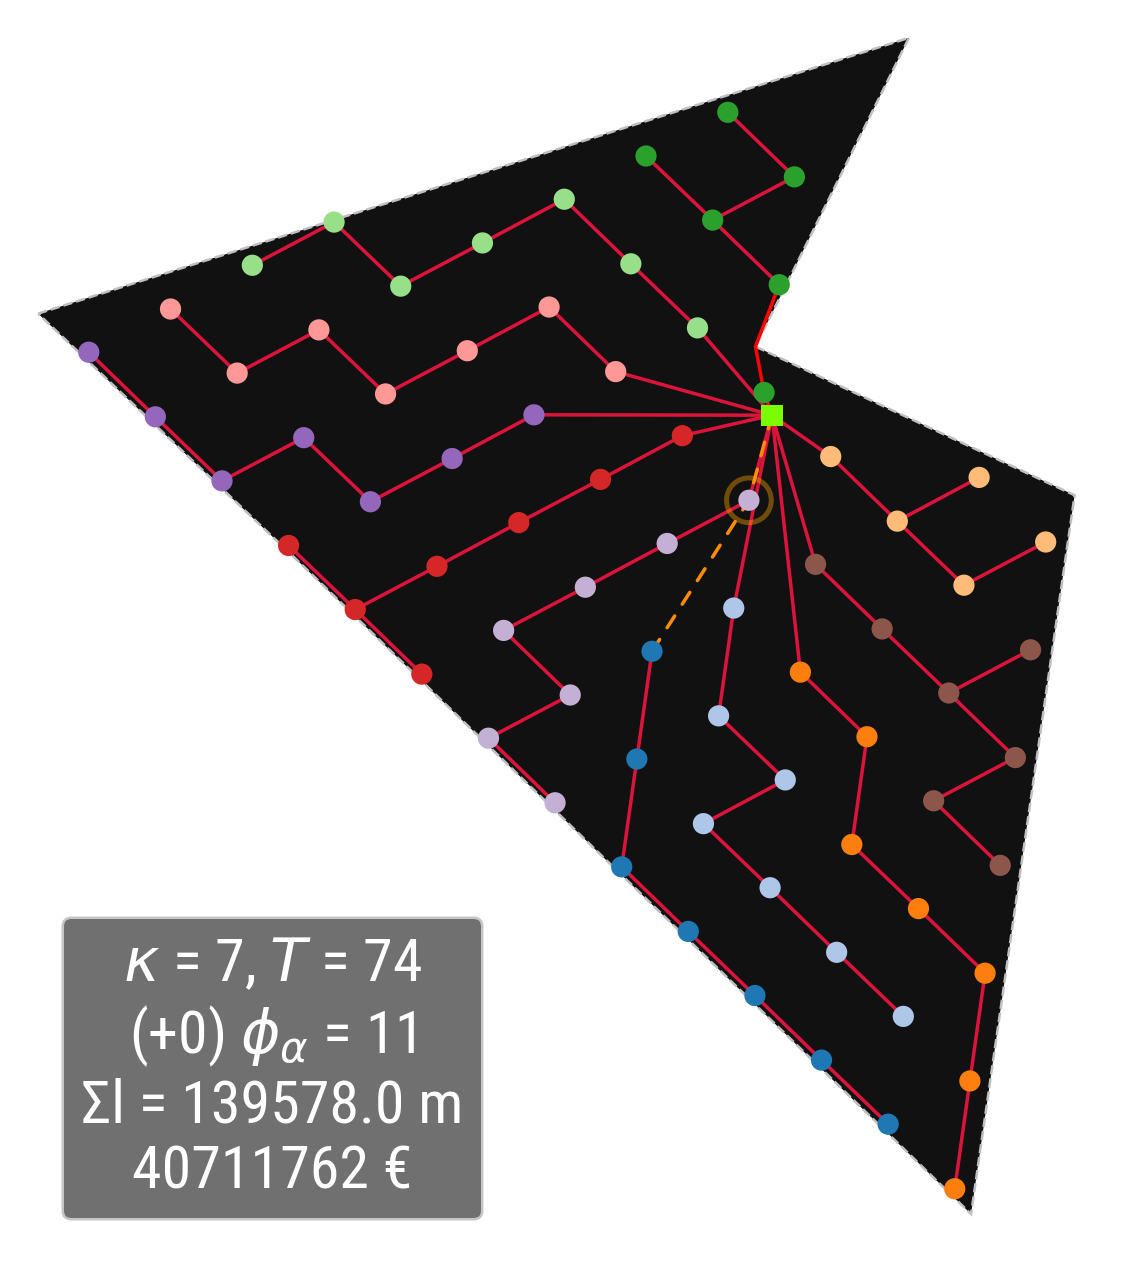

In [23]:
gplot(G_reg, node_tag=None);

In [24]:
solver.options.update(dict(
    timelimit=7,  # [s]
))

## Irregular layout

In [22]:
P, A = make_planar_embedding(L_irr)

In [23]:
# This meta-heuristic call is iterative and the time_limit applies
# to each iteration. About 97% of instances use a single iteration.
S_warm = iterative_hgs_cvrp(as_normalized(A), capacity=capacity, time_limit=3)

In [24]:
m = omo.make_min_length_model(
    A, capacity,
    gateXings_constraint=False,
    branching=True,
    gates_limit=False
)
omo.warmup_model(m, S_warm);

In [25]:
print(f'Solving "{m.name}", capacity = {m.k.value}\n')
status = solver.solve(m, tee=True, warmstart=True)

Solving "IEA37 Borssele Irregular System", capacity = 7

Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.005
Set parameter TimeLimit to value 7
Set parameter MIPFocus to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  7
MIPGap  0.005
MIPFocus  1

Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk
Optimize a model with 1910 rows, 1192 columns and 6654 nonzeros
Model fingerprint: 0xd48a4dae
Variable types: 0 continuous, 1192 integer (596 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [5e+02, 2e+04]
  Bounds range     [1e+00, 7e+00]
  RHS range        [1e+00, 7e+01]

Loaded user MIP start with objective 136451

Presolve removed 260 rows and 0 columns

Loaded user MIP start with objective 152084


Presolve removed 752 rows and 0 columns


Presolve time: 0.45s


Presolved: 2923 rows, 1528 columns, 11606 nonzeros


Variable types: 0 continuous, 1528 integer (764 binary)


Root relaxation: objective 1.355932e+05, 1626 iterations, 0.10 seconds (0.04 work units)


    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


     0     0 135593.250    0  146 152083.980 135593.250  10.8%     -    0s


H    0     0                    152078.33230 135593.250  10.8%     -    0s


H    0     0                    151805.89887 135593.250  10.7%     -    1s


     0     0 136362.916    0  177 151805.899 136362.916  10.2%     -    1s


H    0     0                    150726.38191 136390.136  9.51%     -    1s


     0     0 136390.136    0  187 150726.382 136390.136  9.51%     -    1s


     0     0 136390.136    0  187 150726.382 136390.136  9.51%     -    1s


H    0     0                    150712.21956 136608.324  9.36%     -    1s


     0     0 136608.324    0  215 150712.220 136608.324  9.36%     -    1s


     0     0 136679.462    0  205 150712.220 136679.462  9.31%     -    1s


     0     0 136681.649    0  224 150712.220 136681.649  9.31%     -    1s


     0     0 136681.819    0  244 150712.220 136681.819  9.31%     -    1s


H    0     0                    147988.56258 136788.519  7.57%     -    1s


     0     0 136788.519    0  236 147988.563 136788.519  7.57%     -    1s


H    0     0                    147393.30919 136798.896  7.19%     -    1s


     0     0 136829.221    0  244 147393.309 136829.221  7.17%     -    1s


     0     0 136840.487    0  275 147393.309 136840.487  7.16%     -    1s


     0     0 136842.358    0  261 147393.309 136842.358  7.16%     -    1s


     0     0 136842.358    0  261 147393.309 136842.358  7.16%     -    1s


     0     0 136879.578    0  264 147393.309 136879.578  7.13%     -    1s


     0     0 136899.836    0  265 147393.309 136899.836  7.12%     -    1s


     0     0 136904.212    0  256 147393.309 136904.212  7.12%     -    1s


     0     0 136909.840    0  249 147393.309 136909.840  7.11%     -    1s


     0     0 136911.080    0  274 147393.309 136911.080  7.11%     -    1s


     0     0 136911.372    0  265 147393.309 136911.372  7.11%     -    1s


H    0     0                    147160.12198 136929.795  6.95%     -    1s


     0     0 136929.795    0  278 147160.122 136929.795  6.95%     -    1s


     0     0 136931.096    0  272 147160.122 136931.096  6.95%     -    1s


     0     0 136931.434    0  276 147160.122 136931.434  6.95%     -    1s


     0     0 136931.556    0  276 147160.122 136931.556  6.95%     -    1s


     0     0 136962.618    0  261 147160.122 136962.618  6.93%     -    1s


     0     0 136964.970    0  241 147160.122 136964.970  6.93%     -    1s


     0     0 136966.023    0  260 147160.122 136966.023  6.93%     -    1s


     0     0 136966.524    0  267 147160.122 136966.524  6.93%     -    1s


     0     0 136976.303    0  269 147160.122 136976.303  6.92%     -    1s


     0     0 136984.683    0  278 147160.122 136984.683  6.91%     -    1s


     0     0 136987.330    0  267 147160.122 136987.330  6.91%     -    1s


     0     0 136987.391    0  271 147160.122 136987.391  6.91%     -    1s


H    0     0                    143404.88202 137024.217  4.45%     -    1s


     0     0 137024.217    0  236 143404.882 137024.217  4.45%     -    1s


     0     0 137039.534    0  247 143404.882 137039.534  4.44%     -    1s


     0     0 137039.534    0  291 143404.882 137039.534  4.44%     -    1s


     0     0 137039.534    0  303 143404.882 137039.534  4.44%     -    1s


     0     0 137060.065    0  284 143404.882 137060.065  4.42%     -    2s


H    0     0                    142449.28895 137066.703  3.78%     -    2s


     0     0 137071.175    0  285 142449.289 137071.175  3.78%     -    2s


     0     0 137074.060    0  282 142449.289 137074.060  3.77%     -    2s


     0     0 137075.409    0  290 142449.289 137075.409  3.77%     -    2s


     0     0 137075.444    0  294 142449.289 137075.444  3.77%     -    2s


     0     0 137084.170    0  276 142449.289 137084.170  3.77%     -    2s


     0     0 137086.439    0  298 142449.289 137086.439  3.76%     -    2s


     0     0 137086.764    0  297 142449.289 137086.764  3.76%     -    2s


     0     0 137102.131    0  281 142449.289 137102.131  3.75%     -    2s


     0     0 137108.573    0  296 142449.289 137108.573  3.75%     -    2s


     0     0 137108.612    0  296 142449.289 137108.612  3.75%     -    2s


     0     0 137114.768    0  294 142449.289 137114.768  3.74%     -    2s


     0     0 137116.896    0  300 142449.289 137116.896  3.74%     -    2s


     0     0 137116.896    0  300 142449.289 137116.896  3.74%     -    2s


     0     0 137117.267    0  290 142449.289 137117.267  3.74%     -    2s


     0     0 137117.965    0  288 142449.289 137117.965  3.74%     -    2s


     0     2 137118.050    0  288 142449.289 137118.050  3.74%     -    2s


H   32    56                    141443.21633 137160.936  3.03%   185    3s


H   33    56                    141437.56758 137160.936  3.02%   185    3s


H   36    56                    141114.74864 137160.936  2.80%   179    3s


H  204   228                    141109.10094 137171.900  2.79%   125    4s


H  205   228                    141109.10058 137171.900  2.79%   124    4s


H 1380  1314                    140696.72819 137171.900  2.51%  82.6    4s


  1639  1549 139319.030   49  157 140696.728 137171.900  2.51%  78.3    5s


  2948  2479 138403.284   29  311 140696.728 137372.668  2.36%  68.1   10s


  2966  2491 139517.994    7  340 140696.728 137414.443  2.33%  67.7   15s


H 3077  2456                    140591.46476 137600.419  2.13%  79.8   17s


H 3084  2335                    139593.87897 137600.419  1.43%  80.3   17s


  5064  3045 138493.870   36  269 139593.879 137601.512  1.43%  99.2   20s


  9040  3999 138934.563   36  226 139593.879 137886.819  1.22%   104   25s


 17233  7866     cutoff   38      139593.879 138144.535  1.04%   106   30s


 24237 11273 139055.188   28  224 139593.879 138235.829  0.97%   108   35s


 33241 15151 138546.093   24  221 139593.879 138338.371  0.90%   109   40s


 41675 18470 138790.755   26  236 139593.879 138406.386  0.85%   109   45s


 50374 20426 139315.681   33  288 139593.879 138463.925  0.81%   110   59s


 50377 20428 138931.731   28  262 139593.879 138463.925  0.81%   110   60s


 50406 20447 138489.254   23  316 139593.879 138463.925  0.81%   109   65s


 50425 20460 139076.058   45  339 139593.879 138463.925  0.81%   109   70s


 50440 20470 139502.582   35  333 139593.879 138463.925  0.81%   109   75s


 50456 20481 139096.232   32  337 139593.879 138463.925  0.81%   109   80s


 50471 20491 138822.765   34  345 139593.879 138463.925  0.81%   109   85s


 50488 20502 138944.839   34  349 139593.879 138463.925  0.81%   109   90s


 50504 20513 138931.751   20  349 139593.879 138463.925  0.81%   109   95s


 50518 20522 138709.204   37  363 139593.879 138463.925  0.81%   109  100s


 50698 20661 139449.629   28  254 139593.879 138463.925  0.81%   110  105s


 52579 21061     cutoff   62      139593.879 138463.925  0.81%   111  110s


 57794 21893 139191.817   58  132 139593.879 138463.925  0.81%   110  115s


 63697 22548 138523.962   33  275 139593.879 138463.925  0.81%   110  120s


 68247 22595 138727.191   34  202 139593.879 138463.925  0.81%   109  129s


 68279 22842 138751.637   35  179 139593.879 138463.925  0.81%   109  130s


 74839 23470 139058.266   40  245 139593.879 138463.925  0.81%   109  135s


 78612 23480     cutoff   44      139593.879 138463.925  0.81%   109  145s


 85731 23770 139570.049   35  255 139593.879 138480.473  0.80%   108  150s


 93386 23827 138688.274   43  234 139593.879 138531.170  0.76%   108  155s


 102230 23738     cutoff   34      139593.879 138578.904  0.73%   107  161s


*104052 21643              46    139485.54411 138583.622  0.65%   107  161s


H105586 20554                    139479.89522 138596.740  0.63%   107  163s


 107363 21005     cutoff   66      139479.895 138606.936  0.63%   107  165s


 115109 22506     cutoff   41      139479.895 138641.145  0.60%   107  170s


 123303 23823 139366.644   41  147 139479.895 138680.414  0.57%   106  175s


 132022 24788 138964.979   38  233 139479.895 138720.769  0.54%   106  181s


 136484 25598 139064.998   39  251 139479.895 138738.149  0.53%   106  186s


 146100 26428     cutoff   51      139479.895 138772.593  0.51%   105  191s


 155097 26999 139301.353   40  201 139479.895 138804.676  0.48%   105  196s


 161402 27329 139264.024   37  206 139479.895 138825.023  0.47%   105  200s


 170466 27434     cutoff   43      139479.895 138856.957  0.45%   105  205s


 179676 27365 139146.441   33   91 139479.895 138886.219  0.43%   104  211s


 189337 27285 139384.722   40  236 139479.895 138911.910  0.41%   104  220s


 197028 26820 139098.764   41  254 139479.895 138936.134  0.39%   104  226s


 203858 26314 139172.697   42  233 139479.895 138955.318  0.38%   103  230s


 213570 25314     cutoff   42      139479.895 138986.660  0.35%   103  236s


 220161 24424 139388.758   34  212 139479.895 139006.711  0.34%   103  240s


 229974 22881 139368.220   44  238 139479.895 139037.086  0.32%   102  246s


 236148 21599     cutoff   41      139479.895 139059.113  0.30%   102  250s


 245668 19119 139224.289   44  218 139479.895 139095.569  0.28%   102  256s


 252051 17306 139376.638   34   81 139479.895 139120.405  0.26%   102  260s


 258393 15150 139314.794   37  245 139479.895 139147.669  0.24%   102  265s


 268039 11195 139334.882   47  210 139479.895 139192.730  0.21%   102  271s


Cutting planes:


  Gomory: 35


  Lift-and-project: 17


  Cover: 185


  Implied bound: 10


  Projected implied bound: 5


  MIR: 1009


  StrongCG: 43


  Flow cover: 782


  Flow path: 45


  GUB cover: 1


  Inf proof: 3


  Zero half: 108


  Network: 8


  Relax-and-lift: 4


Explored 271427 nodes (27554559 simplex iterations) in 271.32 seconds (332.14 work units)


Thread count was 24 (of 24 available processors)


Solution count 10: 139480 139486 139594 ... 141443


Optimal solution found (tolerance 2.00e-03)


Best objective 1.394798952160e+05, best bound 1.392114129073e+05, gap 0.1925%


In [26]:
S_solver = omo.S_from_solution(m, solver, status)
G_solver = G_from_S(S_solver, A)
G_irr = PathFinder(G_solver, planar=P, A=A).create_detours()

In [27]:
assign_cables(G_irr, cables)
G_irr.size(weight='cost')

43091183.19165111

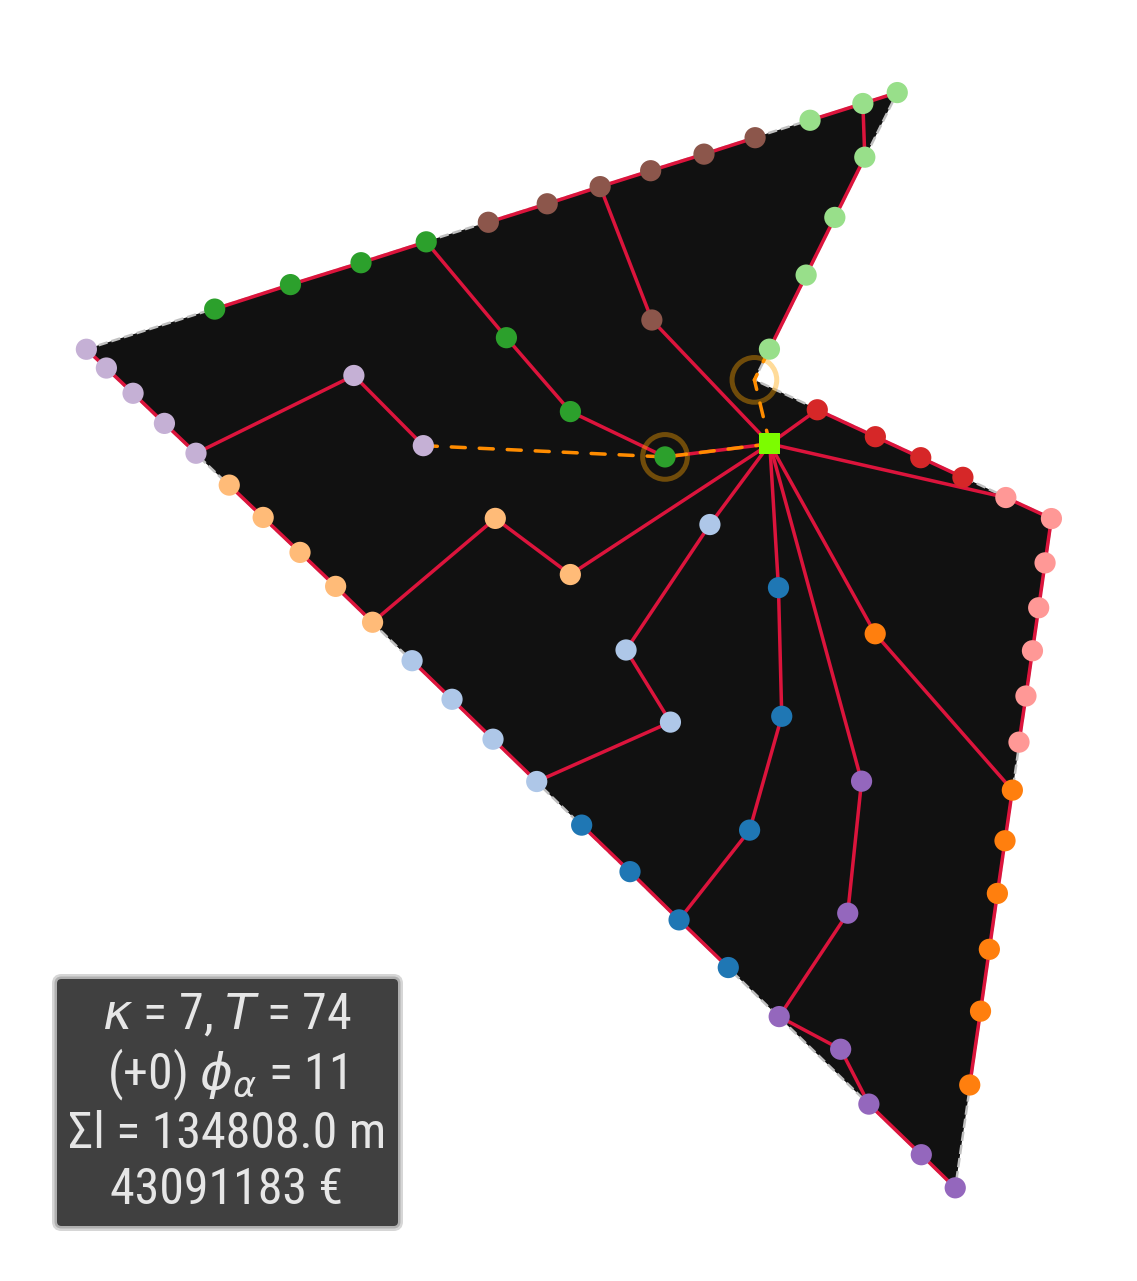

In [28]:
gplot(G_irr, node_tag=None);

## Layouts' edge list

These lists of 3-tuples has all the edges and their cable type (as an index to the `turbines_per_cable` list), i.e. (coordinate_A, coordinate_B, cable_type).

Negative node indices represent substations, the node indices ranging from 0 to 73 represent the WT in the order they were given.

If the layout has contours or detours, indices will go beyond the number of coordinates (WT, SS, borders) provided, and the mapping of these additional indices to indices to the provided coordinates is presented.

In [29]:
G_reg.edges(data='cable')

EdgeDataView([(-1, 47, 2), (-1, 56, 2), (-1, 46, 2), (-1, 33, 2), (-1, 45, 2), (-1, 57, 2), (-1, 34, 2), (-1, 24, 2), (-1, 49, 2), (-1, 58, 2), (-1, 32, 2), (24, 15, 2), (34, 25, 2), (45, 44, 1), (56, 80, 1), (57, 67, 2), (47, 48, 1), (58, 59, 2), (49, 50, 2), (46, 35, 2), (33, 23, 2), (32, 21, 2), (18, 19, 0), (19, 28, 0), (28, 27, 0), (17, 26, 1), (17, 16, 0), (26, 25, 1), (16, 11, 0), (11, 10, 0), (29, 38, 0), (29, 40, 0), (38, 37, 0), (27, 36, 1), (36, 35, 1), (15, 9, 1), (9, 5, 1), (5, 4, 0), (4, 1, 0), (23, 22, 1), (22, 14, 1), (14, 8, 0), (8, 3, 0), (3, 2, 0), (13, 20, 1), (13, 12, 0), (20, 21, 1), (12, 7, 0), (7, 6, 0), (1, 0, 0), (30, 31, 0), (31, 44, 0), (31, 42, 0), (44, 43, 0), (53, 62, 0), (53, 64, 0), (62, 51, 0), (41, 52, 0), (41, 54, 0), (52, 39, 1), (63, 70, 0), (70, 61, 0), (61, 69, 0), (69, 68, 1), (51, 60, 1), (60, 59, 1), (39, 50, 1), (37, 48, 1), (55, 54, 0), (72, 71, 0), (71, 66, 0), (73, 66, 0), (66, 65, 1), (68, 67, 1), (65, 80, 1)])

Mapping of contour/detour node to the index of its VertexC coordinate :

In [30]:
if G_reg.graph.get('C') or G_reg.graph.get('D'):
    R, T, B = (G_reg.graph[k] for k in 'RTB')
    print(dict(enumerate(
        G_reg.graph['fnT'][T + B:-R],
        start=T + B
    )))

{80: 76}


In [31]:
G_irr.edges(data='cable')

EdgeDataView([(-1, 41, 2), (-1, 28, 2), (-1, 49, 2), (-1, 55, 1), (-1, 39, 2), (-1, 60, 2), (-1, 70, 2), (-1, 25, 2), (-1, 33, 2), (-1, 80, 2), (-1, 81, 2), (41, 51, 2), (39, 63, 2), (33, 45, 2), (49, 54, 2), (28, 53, 2), (71, 64, 2), (71, 81, 2), (55, 40, 0), (25, 42, 2), (70, 67, 2), (73, 68, 2), (73, 80, 2), (60, 59, 2), (40, 57, 0), (37, 51, 1), (37, 20, 1), (62, 36, 0), (62, 69, 1), (69, 63, 1), (36, 35, 0), (35, 6, 0), (64, 61, 1), (61, 58, 1), (58, 65, 0), (2, 8, 1), (2, 7, 0), (8, 42, 1), (23, 43, 0), (43, 7, 0), (67, 22, 1), (20, 4, 0), (20, 34, 0), (1, 34, 0), (12, 3, 1), (12, 45, 1), (3, 15, 0), (22, 44, 1), (10, 24, 0), (24, 17, 0), (5, 9, 0), (5, 32, 0), (32, 14, 1), (14, 68, 1), (13, 26, 0), (26, 31, 0), (31, 56, 0), (30, 54, 1), (30, 56, 1), (29, 53, 1), (29, 16, 1), (16, 17, 0), (59, 18, 0), (59, 52, 0), (18, 11, 0), (52, 27, 0), (27, 38, 0), (47, 65, 0), (65, 48, 0), (0, 50, 0), (50, 46, 0), (57, 72, 0), (15, 21, 0), (21, 66, 0), (46, 44, 0), (19, 9, 0)])

Mapping of contour/detour node to the index of its VertexC coordinate :

In [32]:
if G_irr.graph.get('C') or G_irr.graph.get('D'):
    R, T, B = (G_irr.graph[k] for k in 'RTB')
    print(dict(enumerate(
        G_irr.graph['fnT'][T + B:-R],
        start=T + B
    )))

{80: 28, 81: 76}
